In [ ]:
from pandas.core.ops.array_ops import isna
import os
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

movies = pd.read_csv('/content/drive/MyDrive/820/21Jan2023- 820- Movie metadata.csv')


col_names = ["Color", "Director Name", "# Critic Reviews", "Duration", "# Director Likes", "# Actor 1 Likes", "Actor 2 Name", "# Actor 1 Likes", "Gross", "Genres", 
             "Actor 1 Name", "Movie Title", "# Users Voted", "# Cast Likes", "Actor 3 Name", "# FB Poster", "Plot Keywords", "Movie Link", "# Users for Reviews", "Langauge", "Country",
             "Content Rating", "Budget", "Title Year", "# Actor 2 Likes", "IMDB Score", "Aspect Ratio", "# Movie Likes"]
movies.columns = col_names

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#REMOVE MISSING DATA:
movies = movies.dropna()
pd.set_option('float_format', '{:.2f}'.format)
show_Missing = movies.isna().sum()
show_Missing


Color                  0
Director Name          0
# Critic Reviews       0
Duration               0
# Director Likes       0
# Actor 1 Likes        0
Actor 2 Name           0
# Actor 1 Likes        0
Gross                  0
Genres                 0
Actor 1 Name           0
Movie Title            0
# Users Voted          0
# Cast Likes           0
Actor 3 Name           0
# FB Poster            0
Plot Keywords          0
Movie Link             0
# Users for Reviews    0
Langauge               0
Country                0
Content Rating         0
Budget                 0
Title Year             0
# Actor 2 Likes        0
IMDB Score             0
Aspect Ratio           0
# Movie Likes          0
dtype: int64

In [ ]:
from pandas.core.groupby.grouper import DataFrame
#CREATE REVENUE CATEGORIES:

#Revenue Classes:
# $0 - 24.99M
# $25 - 99.99M
# $100 - 249.99M
# $250 - 499.99M
# $500M - 1000000000

#Assign each movie to a REVENUE CLASS:
movies['Classes'] = pd.cut(movies.Gross, bins = [0, 24999999, 99999999,249999999, 499999999, 1000000000], 
       labels = ['Class 1','Class 2', 'Class 3', 'Class 4', 'Class 5'])

In [ ]:
#Remove unwanted features:
movies = movies.drop(['Movie Title', 'Movie Link', 'Plot Keywords'], axis = 1) 

# Set aside the Classes label for future train-test splitting:
y = movies.pop('Classes')

KeyError: ignored

In [ ]:
# ENCODE CATEGORICAL VARIABLES TO NUMERICAL LABEL ENCODING:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
one_hot_encoder = preprocessing.OneHotEncoder()

movies['Director Name'] = label_encoder.fit_transform(movies['Director Name'])
movies['Color'] = label_encoder.fit_transform(movies['Color'])
movies['Actor 2 Name'] = label_encoder.fit_transform(movies['Actor 2 Name'])
movies['Genres'] = label_encoder.fit_transform(movies['Genres'])
movies['Langauge'] = label_encoder.fit_transform(movies['Langauge'])
movies['Country'] = label_encoder.fit_transform(movies['Country'])
movies['Content Rating'] = label_encoder.fit_transform(movies['Content Rating'])
movies['Title Year'] = label_encoder.fit_transform(movies['Title Year'])
movies['Actor 1 Name'] = label_encoder.fit_transform(movies['Actor 1 Name'])
movies['Actor 3 Name'] = label_encoder.fit_transform(movies['Actor 3 Name'])

movies.head()

,Color,Director Name,# Critic Reviews,Duration,# Director Likes,# Actor 1 Likes,Actor 2 Name,# Actor 1 Likes,Gross,Genres,...,# Users for Reviews,Langauge,Country,Content Rating,Budget,Title Year,# Actor 2 Likes,IMDB Score,Aspect Ratio,# Movie Likes
0,1,620,723.00,178.00,0.00,855.00,1002,1000.00,760505847.00,91,...,3054.00,9,43,7,237000000.00,66,936.00,7.90,1.78,33000
1,1,538,302.00,169.00,563.00,1000.00,1592,40000.00,309404152.00,85,...,1238.00,9,43,7,300000000.00,64,5000.00,7.10,2.35,0
2,1,1395,602.00,148.00,0.00,161.00,1795,11000.00,200074175.00,107,...,994.00,9,42,7,245000000.00,72,393.00,6.80,2.35,85000
3,1,251,813.00,164.00,22000.00,23000.00,381,27000.00,448130642.00,243,...,2701.00,9,43,7,250000000.00,69,23000.00,8.50,2.35,164000
5,1,62,462.00,132.00,475.00,530.00,1837,640.00,73058679.00,105,...,738.00,9,43,7,263700000.00,69,632.00,6.60,2.35,24000


In [ ]:
#NORMALIZE DATA
from sklearn.preprocessing import MinMaxScaler
#Scale the variables:

scaler = MinMaxScaler()
scaler.fit(movies)
scaled_Movies = scaler.fit_transform(movies)
scaled_Movies = pd.DataFrame(scaled_Movies, columns = movies.columns)
print(scaled_Movies.head())

   Color  Director Name  # Critic Reviews  Duration  # Director Likes  \
0   1.00           0.37              0.89      0.48              0.00   
1   1.00           0.32              0.37      0.45              0.02   
2   1.00           0.84              0.74      0.38              0.00   
3   1.00           0.15              1.00      0.43              0.96   
4   1.00           0.04              0.57      0.32              0.02   

   # Actor 1 Likes  Actor 2 Name  # Actor 1 Likes  Gross  Genres  ...  \
0             0.04          0.46             0.00   1.00    0.12  ...   
1             0.04          0.73             0.06   0.41    0.11  ...   
2             0.01          0.82             0.02   0.26    0.14  ...   
3             1.00          0.17             0.04   0.59    0.33  ...   
4             0.02          0.84             0.00   0.10    0.14  ...   

   # Users for Reviews  Langauge  Country  Content Rating  Budget  Title Year  \
0                 0.60      0.27     0.98

In [ ]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#SEPARATE INTO TRAINING AND TEST SETS:
X = scaled_Movies


In [ ]:
# RANDOM SPLIT- SPLIT DATA INTO TRAINING AND TEST SETS:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, train_size = 0.8, shuffle = True)

In [ ]:
# GAUSSIAN NAIVE BAYES MODEL:
from sklearn.naive_bayes import GaussianNB

gnb_Model = GaussianNB()
gnb_Model.fit(X_train, y_train)
gnb_Predictions = gnb_Model.predict(X_test)
gnb_Predictions[0:20]

array(['Class 1', 'Class Four', 'Class 2', 'Class 1', 'Class 2',
       'Class 1', 'Class Four', 'Class Four', 'Class 1', 'Class Four',
       'Class 1', 'Class 1', 'Class Four', 'Class 1', 'Class 2',
       'Class 1', 'Class 2', 'Class 1', 'Class 1', 'Class Four'],
      dtype='<U10')

In [ ]:
# SUPPORT VECTOR MACHINE MODEL:
from sklearn import svm

svm_Model = svm.SVC(kernel = 'linear') 
svm_Model.fit(X_train, y_train)
svm_Predictions = svm_Model.predict(X_test)
svm_Predictions[0:20]

array(['Class 1', 'Class 3', 'Class 2', 'Class 1', 'Class 1', 'Class 1',
       'Class 3', 'Class 2', 'Class 1', 'Class 2', 'Class 1', 'Class 1',
       'Class 3', 'Class 1', 'Class 2', 'Class 1', 'Class 2', 'Class 1',
       'Class 1', 'Class 3'], dtype=object)

In [ ]:
#DECISION TREE MODEL:
from sklearn import tree

#TEST TREE MODEL:
tree_Model = tree.DecisionTreeClassifier()
tree_Model = tree_Model.fit(X_train, y_train)
tree_Predictions = tree_Model.predict(X_test)
tree_Predictions[0:20]


array(['Class 1', 'Class 3', 'Class 2', 'Class 1', 'Class 2', 'Class 1',
       'Class 3', 'Class 2', 'Class 1', 'Class 2', 'Class 1', 'Class 1',
       'Class 3', 'Class 1', 'Class 2', 'Class 1', 'Class 2', 'Class 1',
       'Class 1', 'Class 3'], dtype=object)

In [ ]:
#############################
#LOGISTIC REGRESSION MODEL
from sklearn import linear_model
movie_Model = linear_model.LogisticRegression(multi_class = 'ovr', solver = 'liblinear')
movie_Model.fit(X_train, y_train)
log_Predictions = movie_Model.predict(X_test)
log_Predictions[0:20]

array(['Class 1', 'Class 3', 'Class 1', 'Class 1', 'Class 1', 'Class 1',
       'Class 2', 'Class 2', 'Class 1', 'Class 2', 'Class 1', 'Class 1',
       'Class 3', 'Class 1', 'Class 2', 'Class 1', 'Class 2', 'Class 1',
       'Class 1', 'Class 2'], dtype=object)

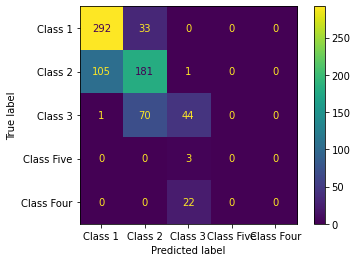

In [ ]:
# Logistic Regression Confusion Matrix:

cm_log = confusion_matrix(y_test, log_Predictions, labels = movie_Model.classes_)
disp_log =  ConfusionMatrixDisplay(confusion_matrix = cm_log, display_labels = movie_Model.classes_)
disp_log.plot()
plt.show()

In [ ]:
from sklearn import metrics

# ACCURACY SCORES OF EACH ALGORITHM:
print("Accuracy: LOGISTIC REGRESSION:", metrics.accuracy_score(y_test, log_Predictions))
print("Accuracy: GAUSSIAN NAIVE BAYES:", metrics.accuracy_score(y_test, gnb_Predictions))
print("Accuracy: SVM:", metrics.accuracy_score(y_test, svm_Predictions))
print("Accuracy: DECISION TREE:", metrics.accuracy_score(y_test, tree_Predictions))

Accuracy: LOGISTIC REGRESSION: 0.6875
Accuracy: GAUSSIAN NAIVE BAYES: 0.625
Accuracy: SVM: 0.8723404255319149
Accuracy: DECISION TREE: 0.9986702127659575


In [ ]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# CROSS- VALIDATION- SPLIT DATA INTO TRAINING AND TEST SETS:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

# CROSS- VAL: Gaussian Naive Bayes 
k_folds = KFold(n_splits=10)
gnb_cross_Scores = cross_val_score(gnb_Model, X_test, y_test, cv = k_folds)
gnb_cross_Scores

array([0.30263158, 0.31578947, 0.28      , 0.25333333, 0.24      ,
       0.33333333, 0.28      , 0.29333333, 0.28      , 0.32      ])

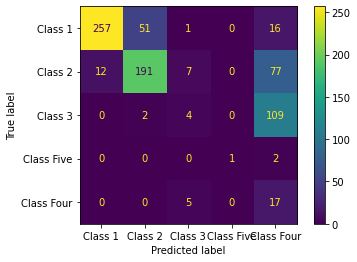

In [ ]:
# Gaussian Naive Bayes Confusion Matrix:

cm_gnb = confusion_matrix(y_test, gnb_Predictions, labels = gnb_Model.classes_)
disp_gnb =  ConfusionMatrixDisplay(confusion_matrix = cm_gnb, display_labels = gnb_Model.classes_)
disp_gnb.plot()
plt.show()

In [ ]:
# CROSS- VAL: Support Vector Machine:
k_folds = KFold(n_splits = 10)
svm_cross_Scores = cross_val_score(svm_Model, X_test, y_test, cv = k_folds)
svm_cross_Scores

array([0.78947368, 0.82894737, 0.72      , 0.69333333, 0.70666667,
       0.62666667, 0.61333333, 0.82666667, 0.70666667, 0.69333333])

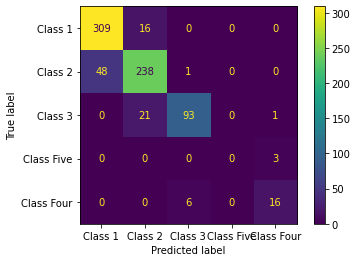

In [ ]:
# Support Vector Machine Confusion Matrix:

cm_svm = confusion_matrix(y_test, svm_Predictions, labels = svm_Model.classes_)
disp_svm =  ConfusionMatrixDisplay(confusion_matrix = cm_svm, display_labels = svm_Model.classes_)
disp_svm.plot()
plt.show()

In [ ]:
# CROSS- VAL: Decision Tree:
k_folds = KFold(n_splits = 10)
tree_cross_Scores = cross_val_score(tree_Model, X_test, y_test, cv = k_folds)
tree_cross_Scores

array([1.        , 0.98684211, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

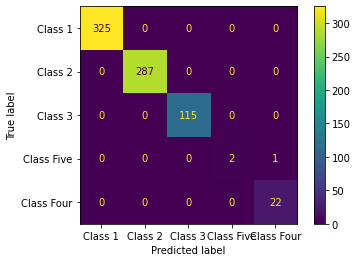

In [ ]:
# Decision Tree Confusion Matrix:
cm_Tree = confusion_matrix(y_test, tree_Predictions, labels = tree_Model.classes_)
disp_Tree =  ConfusionMatrixDisplay(confusion_matrix = cm_Tree, display_labels = tree_Model.classes_)
disp_Tree.plot()
plt.show()